This is my attempt to run a simple retrospective hotspotting analysis on Chicago data, following along the notebook located at:

PredictCode/examples/Case%20Study%20Chicago%20South%20Side/Retrohotspot.ipynb

That notebook focuses on importing code from a `common.py` file that then imports code from the `open_cp` library. I will attempt to make things less opaque by including `common.py` code here in this notebook, and adding more comments throughout.

Some goals:
* Load the Chicago data
* Mask the area so that we only look at the irregular Chicago polygon and not a full rectangular region
* Run a Gaussian KDE on the data within some timeframe and then obtain a prediction for future risk
* Rank cells by level of predicted risk
* Evaluate prediction by graphing the crime that arises in test data within the top x% of identified highest-risk cells, with the coverage x varying

In [2]:
# Some fairly standard modules
import os, csv, lzma
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import descartes

# The geopandas module does not come standard with anaconda,
# so you'll need to run the anaconda prompt as an administrator
# and install it via "conda install -c conda-forge geopandas".
# That installation will include pyproj and shapely automatically.
# These are useful modules for plotting geospatial data.
import geopandas as gpd
import pyproj
import shapely.geometry

# These modules are useful for tracking where modules are
# imported from, e.g., to check we're using our local edited
# versions of open_cp scripts.
import sys
import inspect
import importlib

# In order to use our local edited versions of open_cp
# scripts, we insert the parent directory of the current
# file ("..") at the start of our sys.path here.
sys.path.insert(0, os.path.abspath(".."))

# Elements from PredictCode's custom "open_cp" package
import open_cp
import open_cp.geometry
import open_cp.plot
import open_cp.sources.chicago as chicago

In [3]:
# Declare location of data directory for Chicago data
datadir = os.path.join("..", "..", "Data")
chicago.set_data_directory(datadir)

In [4]:
# Read data from CSV or CSV.XZ file, view first two rows

def get_csv_data(shortfilename="chicago.csv"):
    filename = os.path.join(datadir, shortfilename)
    if shortfilename.endswith(".csv.xz"):
        with lzma.open(filename, "rt") as f:
            yield from csv.reader(f)
    elif shortfilename.endswith(".csv"):
        with open(filename, "rt") as f:
            yield from csv.reader(f)
    else:
        yield None

rows = get_csv_data("chicago.csv")
print(next(rows))
print(next(rows))

['CASE#', 'DATE  OF OCCURRENCE', 'BLOCK', ' IUCR', ' PRIMARY DESCRIPTION', ' SECONDARY DESCRIPTION', ' LOCATION DESCRIPTION', 'ARREST', 'DOMESTIC', 'BEAT', 'WARD', 'FBI CD', 'X COORDINATE', 'Y COORDINATE', 'LATITUDE', 'LONGITUDE', 'LOCATION']
['JB241987', '04/28/2018 10:05:00 PM', '009XX N LONG AVE', '2092', 'NARCOTICS', 'SOLICIT NARCOTICS ON PUBLICWAY', 'SIDEWALK', 'Y', 'N', '1524', '37', '18', '1140136', '1905903', '41.897894893', '-87.760743714', '(41.897894893, -87.760743714)']


In [6]:
# Obtain polygon shapely object for South side

south_side_polygon = chicago.get_side("South")

# Obtain GeoDataFrame with polygon's geometry
#  and with CRS epsg:2790
frame = gpd.GeoDataFrame({"name":["South Side"]})
frame.geometry = [south_side_polygon]
frame.crs = {"init":"epsg:2790"}

In [7]:
# Obtain Chicago burglary data
#points = chicago.default_burglary_data()
datafilepath = os.path.join(datadir, "chicago.csv")
points = chicago.load(datafilepath, {"THEFT"})

# View initial features of the data
print("Number of timestamps: " + str(len(points.timestamps)))
print("Earliest time: " + str(points.time_range[0]))
print("Latest time: " + str(points.time_range[1]))
bbox = points.bounding_box
print("X coord range:", bbox.xmin, bbox.xmax)
print("Y coord range:", bbox.ymin, bbox.ymax)
print("Aspect ratio: " + str(bbox.aspect_ratio))


Number of timestamps: 63792
Earliest time: 2018-02-12T06:00:00.000
Latest time: 2019-02-11T23:39:00.000
X coord range: 333057.45491490985 367317.9578359157
Y coord range: 552876.9113538227 594816.256032512
Aspect ratio: 1.224131028531268


In [8]:
# Get masked grid

grid_250 = open_cp.data.Grid(xsize=250, ysize=250, xoffset=0, yoffset=0)
masked_grid = open_cp.geometry.mask_grid_by_intersection(south_side_polygon, grid_250)

print("Total number of cells in region:", masked_grid.xextent * masked_grid.yextent)
print("Number of cells which intersect geometry:", np.sum(~masked_grid.mask))

grid_250_120 = open_cp.data.Grid(xsize=250, ysize=250, xoffset=120, yoffset=120)
masked_grid_120 = open_cp.geometry.mask_grid_by_intersection(south_side_polygon, grid_250_120)

print("Total number of cells in region:", masked_grid_120.xextent * masked_grid_120.yextent)
print("Number of cells which intersect geometry:", np.sum(~masked_grid_120.mask))

Total number of cells in region: 2058
Number of cells which intersect geometry: 961
Total number of cells in region: 2064
Number of cells which intersect geometry: 955


<class 'numpy.ndarray'>
<class 'matplotlib.axes._subplots.AxesSubplot'>


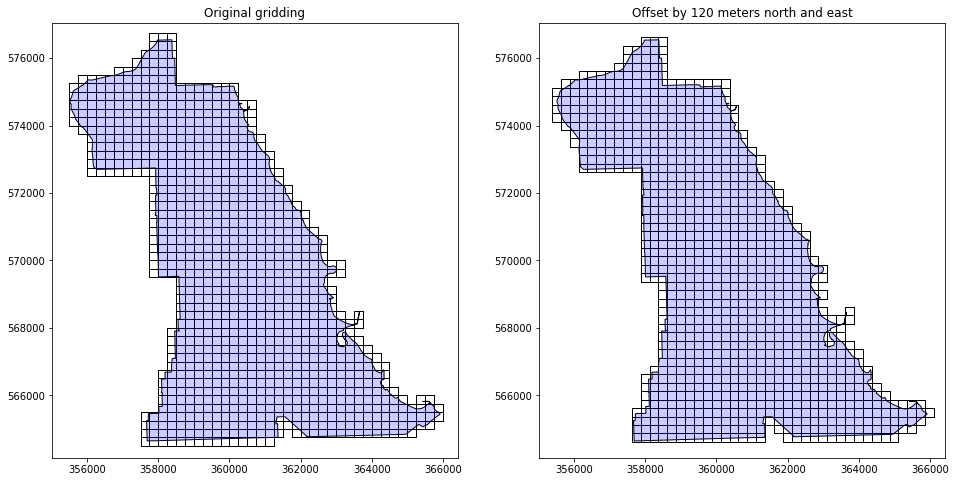

In [11]:
fig, ax  = plt.subplots(ncols=2, figsize=(16,8))

print(type(ax))
print(type(ax[0]))

for a in ax:
    a.add_patch(descartes.PolygonPatch(south_side_polygon, fc="none", ec="Black"))
    a.add_patch(descartes.PolygonPatch(south_side_polygon, fc="Blue", ec="none", alpha=0.2))
    xmin, ymin, xmax, ymax = south_side_polygon.bounds
    a.set(xlim=[xmin-500,xmax+500], ylim=[ymin-500,ymax+500])

pc = open_cp.plot.patches_from_grid(masked_grid)
ax[0].add_collection(matplotlib.collections.PatchCollection(pc, facecolor="None", edgecolor="black"))
pc = open_cp.plot.patches_from_grid(masked_grid_120)
ax[1].add_collection(matplotlib.collections.PatchCollection(pc, facecolor="None", edgecolor="black"))
ax[0].set_title("Original gridding")
ax[1].set_title("Offset by 120 meters north and east")
None

In [53]:
# Create retrospective hotspotting predictors

importlib.reload(open_cp.predictors)
import open_cp.retrohotspot as retro

start_date = "2018-03-01"
end_date = "2018-10-01"
eval_start_date = "2018-09-01"
eval_end_date = "2018-10-01"


cts_pred = retro.RetroHotSpot()
cts_pred.data = points
cts_pred.weight = retro.Quartic(bandwidth = 1000)
cts_risk = cts_pred.predict(start_time = np.datetime64(start_date), end_time = np.datetime64(end_date))
cts_grid_risk = open_cp.predictors.grid_prediction(cts_risk, masked_grid)


self.samples
12
self._samples
12
self.__samples
None
width and height :
42
49
prediction.samples :
12
Calling prediction.to_matrix(width,height)
self.samples 
12
self.cell_width and height 
250
250
gonna make GridPredictionArray...


In [54]:
# Grid-based retrospective hotspotting predictor
grid_pred = retro.RetroHotSpotGrid(grid=masked_grid)
grid_pred.data = points
grid_pred.weight = retro.Quartic(bandwidth = 1000)
grid_risk = grid_pred.predict(start_time = np.datetime64(start_date), end_time = np.datetime64(end_date))
grid_risk.mask_with(masked_grid)

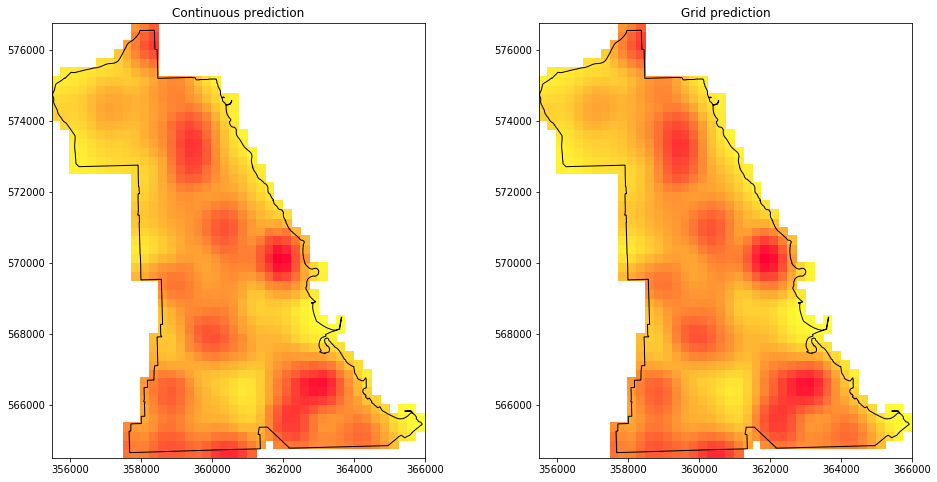

In [55]:
fig, ax  = plt.subplots(ncols=2, figsize=(16,8))

_cdict = {'red':   [(0.0,  1.0, 1.0),
                   (1.0,  1.0, 1.0)],
         'green': [(0.0,  1.0, 1.0),
                   (1.0,  0.0, 0.0)],
         'blue':  [(0.0,  0.2, 0.2),
                   (1.0,  0.2, 0.2)]}

yellow_to_red = matplotlib.colors.LinearSegmentedColormap("yellow_to_red", _cdict)

for a in ax:
    a.set_aspect(1)
    a.add_patch(descartes.PolygonPatch(south_side_polygon, fc="none", ec="Black"))
    
ax[0].pcolormesh(*cts_grid_risk.mesh_data(), cts_grid_risk.intensity_matrix, cmap=yellow_to_red)
ax[0].set_title("Continuous prediction")
ax[1].pcolormesh(*grid_risk.mesh_data(), grid_risk.intensity_matrix, cmap=yellow_to_red)
ax[1].set_title("Grid prediction")
None

In [56]:
import open_cp.evaluation

eval_time_range = open_cp.evaluation.HitRateEvaluator.time_range(np.datetime64(eval_start_date),
            np.datetime64(eval_end_date), np.timedelta64(1, "D"))

class RetroHotSpotEval(open_cp.evaluation.PredictionProvider):
    def __init__(self, masked_grid, points, time_window_length = np.timedelta64(56, "D")):
        self.time_window_length = time_window_length
        self.masked_grid = masked_grid
        self.points = points
    
    def predict(self, time):
        grid_pred = retro.RetroHotSpotGrid(grid=self.masked_grid)
        grid_pred.data = self.points
        grid_pred.weight = retro.Quartic(bandwidth = 1000)
        grid_risk = grid_pred.predict(start_time = time - self.time_window_length, end_time = time)
        grid_risk.mask_with(self.masked_grid)
        return grid_risk

evaluator = open_cp.evaluation.HitRateEvaluator(RetroHotSpotEval(masked_grid, points))
evaluator.data = points
result = evaluator.run(eval_time_range, range(0,51))

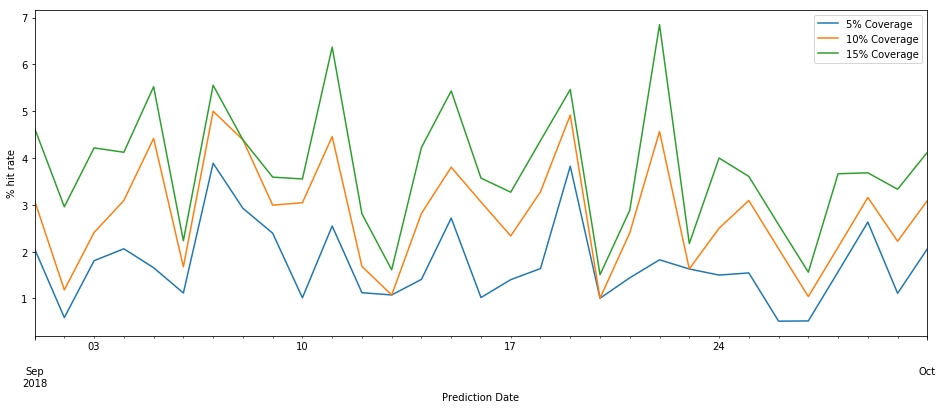

In [57]:
import pandas

frame = pandas.DataFrame(result.rates).T
frame.index.name = "Prediction Date"
frame.columns.name = "% Coverage"

fig, ax = plt.subplots(figsize=(16,6))
(frame[5] * 100).plot(ax=ax)
(frame[10] * 100).plot(ax=ax)
(frame[15] * 100).plot(ax=ax)
ax.set_ylabel("% hit rate")
ax.legend(["{}% Coverage".format(x) for x in [5,10,15]])
None